In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [3]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [4]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

(16,)

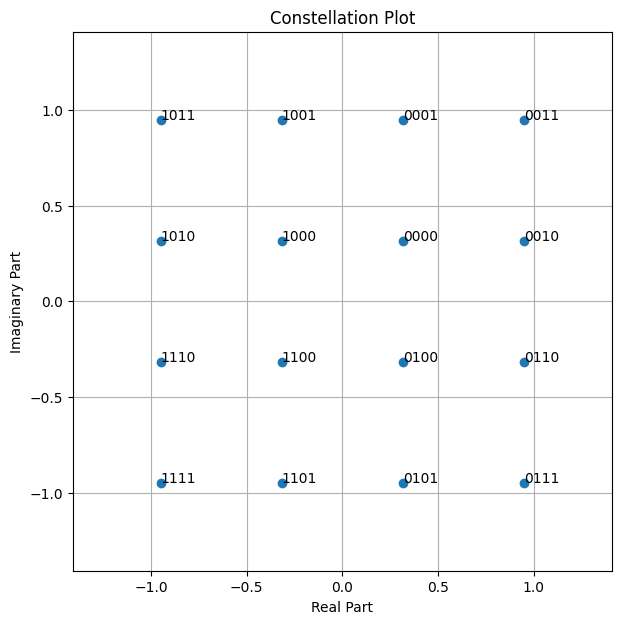

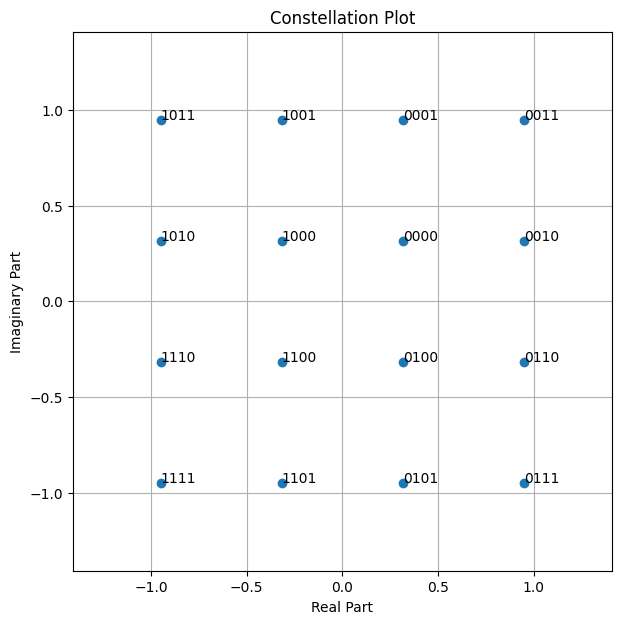

In [5]:
show(points, NUM_BITS_PER_SYMBOL)

In [6]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [7]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [8]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [9]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [10]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)

In [11]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(16,)


In [12]:
onesample = dataset[0]

In [13]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [14]:
onesample['samples'].shape

torch.Size([64, 256])

In [15]:
onesample['labels'].shape

(64, 1024)

In [16]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [17]:
onebatch = next(iter(val_loader))

In [18]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [19]:
onebatch = next(iter(train_loader))

In [20]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [21]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [22]:
class Simplemodel(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[64, 64, 512]
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 64, 64, 512]
        z = z.permute(1, 2, 3, 0) #[64, 64, 512, 2]
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[64, 64, 512, num_bits_per_symbol]
        z = z.flatten(-2, -1) #combine last two dimension => [64, 64, 512*num_bits_per_symbol]
        return z

In [23]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [24]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [25]:
output.shape

torch.Size([32, 64, 1024])

In [26]:
output.dtype

torch.float32

In [27]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [28]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [29]:
loss_fn(test,test)

tensor(0.)

In [30]:
onebatch['labels'].dtype

torch.float32

In [31]:
loss_fn(output,onebatch['labels'])

tensor(0.7164, grad_fn=<BinaryCrossEntropyBackward0>)

In [32]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output\exp0212


In [33]:
train_losses = []
val_losses = []
val_BERs = []

In [34]:
model=model.to(device)

In [35]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.6524, Val Loss: 0.7368, Val BER: 0.2928


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.6139, Val Loss: 0.6462, Val BER: 0.2196


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.6020, Val Loss: 0.8993, Val BER: 0.2102


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.5954, Val Loss: 0.5131, Val BER: 0.2137


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.5906, Val Loss: 0.5111, Val BER: 0.2141


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.5865, Val Loss: 0.4937, Val BER: 0.2113


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.5828, Val Loss: 0.5865, Val BER: 0.2098


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.5794, Val Loss: 0.4955, Val BER: 0.2119


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.5760, Val Loss: 0.4743, Val BER: 0.2112


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.5728, Val Loss: 0.6586, Val BER: 0.2063


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.5697, Val Loss: 0.7149, Val BER: 0.2081


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.5666, Val Loss: 0.7427, Val BER: 0.2112


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.5635, Val Loss: 0.4541, Val BER: 0.2051


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.5604, Val Loss: 0.4554, Val BER: 0.2103


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.5574, Val Loss: 0.7277, Val BER: 0.2084


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.5543, Val Loss: 0.5339, Val BER: 0.2072


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.5512, Val Loss: 0.4442, Val BER: 0.2063


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.5482, Val Loss: 0.5711, Val BER: 0.2075


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.5451, Val Loss: 0.5908, Val BER: 0.2043


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.5420, Val Loss: 0.4335, Val BER: 0.2027


In [36]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

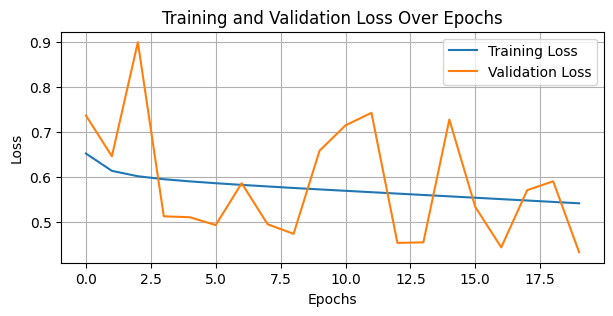

In [37]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

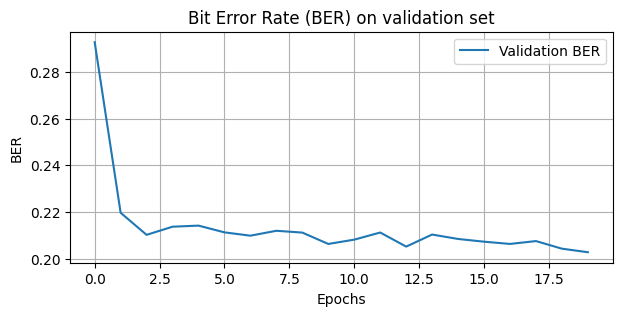

In [38]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

In [39]:
class ComplexBCELoss(nn.Module):
    def __init__(self):
        super(ComplexBCELoss, self).__init__()

    def forward(self, output, target):
        if output.dtype == torch.complex64:
            # Compute BCE loss separately for real and imaginary parts
            loss_real = nn.BCELoss()(output.real, target.real)
            loss_imag = nn.BCELoss()(output.imag, target.imag)
            return loss_real + loss_imag
        else:
            # If the output is not complex, compute BCE loss directly
            return nn.BCELoss()(output, target)

In [40]:
class EnhancedModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(EnhancedModel, self).__init__()
        scale = 16  # Increase the scale for a more complex model
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Add dropout for regularization

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.dropout(z)  # Apply dropout
        z = self.linear2(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [42]:
import torch.nn.functional as F

class ComplexConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ComplexConv2d, self).__init__()
        self.conv_real = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.conv_imag = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        real = self.conv_real(x.real) - self.conv_imag(x.imag)
        imag = self.conv_real(x.imag) + self.conv_imag(x.real)
        return torch.complex(real, imag)

# Usage in your ComplexModel
class ComplexModel(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(ComplexModel, self).__init__()
        # Define your complex model architecture here
        self.conv1 = ComplexConv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = ComplexConv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(32 * H * W, num_bits_per_symbol, bias=False)

    def forward(self, inputs):
        # Implement the forward pass for your complex model
        x = inputs

        # Replace the following with your actual model architecture
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x





In [43]:
loss_fn = ComplexBCELoss()

In [44]:
model_configs = [
    {'model': Simplemodel, 'name': 'Simple Model'},
    {'model': EnhancedModel, 'name': 'Enhanced Model'},
   # {'model': ComplexModel, 'name': 'Complex Model'},
]

In [45]:
def evaluate_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    total_ber = 0.0

    with torch.no_grad():
        for data_batch in loader:
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            outputs = model(samples)
            loss = loss_fn(outputs, labels)

            binary_predictions = torch.round(outputs)
            error_count = torch.sum(binary_predictions != labels).float()
            error_rate = error_count / len(labels.flatten())
            total_ber += error_rate.item()

            total_loss += loss.item()

    average_loss = total_loss / len(loader)
    average_ber = total_ber / len(loader)

    return average_loss, average_ber

In [46]:
results=[]

Adam optimizer

In [47]:
from tqdm.auto import tqdm
import torch.nn.functional as F
# Training loop

for config in model_configs:
    model_class = config['model']
    model_name = config['name']

    model = model_class(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = ComplexBCELoss() if model_class == EnhancedModel else nn.BCELoss()

    train_losses = []
    val_losses = []
    train_BERs = []
    val_BERs = []

    start_epoch = 0
    num_epochs =20
    for epoch in range(start_epoch, num_epochs):
        total_loss = 0.0
        model.train()  # Set the model to training mode

        for index, data_batch in enumerate(tqdm(train_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            outputs = model(samples)  # forward pass
            loss = loss_fn(outputs, labels)
            loss.backward()  # backward pass
            optimizer.step()  # update the weights
            total_loss += loss.item()  # accumulate the loss
            optimizer.zero_grad()  # Zero the gradients

        # Print average loss for the epoch
        average_loss = total_loss / len(train_loader)
        train_losses.append(average_loss)

         # Evaluate on validation set
        val_loss, val_ber = evaluate_model(model, val_loader, loss_fn, device)
        val_losses.append(val_loss)
        val_BERs.append(val_ber)

        print(f"{model_name} - Epoch [{epoch + 1}/{num_epochs}], "
              f"Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {val_ber:.4f}")

    results.append({'name': model_name, 'train_losses': train_losses, 'val_losses': val_losses,
                    'train_BERs': train_BERs, 'val_BERs': val_BERs})

  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [1/20], Loss: 0.6799, Val Loss: 0.6454, Val BER: 0.3136


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [2/20], Loss: 0.6272, Val Loss: 0.6069, Val BER: 0.2309


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [3/20], Loss: 0.6003, Val Loss: 0.5851, Val BER: 0.2060


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [4/20], Loss: 0.5844, Val Loss: 0.5711, Val BER: 0.1947


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [5/20], Loss: 0.5723, Val Loss: 0.5591, Val BER: 0.1883


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [6/20], Loss: 0.5607, Val Loss: 0.5477, Val BER: 0.1910


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [7/20], Loss: 0.5490, Val Loss: 0.5360, Val BER: 0.1848


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [8/20], Loss: 0.5368, Val Loss: 0.5234, Val BER: 0.1833


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [9/20], Loss: 0.5242, Val Loss: 0.5111, Val BER: 0.1822


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [10/20], Loss: 0.5125, Val Loss: 0.5000, Val BER: 0.1815


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [11/20], Loss: 0.5021, Val Loss: 0.4898, Val BER: 0.1811


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [12/20], Loss: 0.4933, Val Loss: 0.4816, Val BER: 0.1816


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [13/20], Loss: 0.4860, Val Loss: 0.4747, Val BER: 0.1812


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [14/20], Loss: 0.4799, Val Loss: 0.4690, Val BER: 0.1816


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [15/20], Loss: 0.4749, Val Loss: 0.4638, Val BER: 0.1813


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [16/20], Loss: 0.4707, Val Loss: 0.4599, Val BER: 0.1815


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [17/20], Loss: 0.4672, Val Loss: 0.4565, Val BER: 0.1818


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [18/20], Loss: 0.4643, Val Loss: 0.4536, Val BER: 0.1817


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [19/20], Loss: 0.4617, Val Loss: 0.4511, Val BER: 0.1819


  0%|          | 0/80 [00:00<?, ?it/s]

Simple Model - Epoch [20/20], Loss: 0.4597, Val Loss: 0.4490, Val BER: 0.1819


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [1/20], Loss: 0.6702, Val Loss: 0.6146, Val BER: 0.2218


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [2/20], Loss: 0.6172, Val Loss: 0.5906, Val BER: 0.2268


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [3/20], Loss: 0.6037, Val Loss: 0.5777, Val BER: 0.1997


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [4/20], Loss: 0.5955, Val Loss: 0.5693, Val BER: 0.1870


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [5/20], Loss: 0.5897, Val Loss: 0.5625, Val BER: 0.1862


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [6/20], Loss: 0.5858, Val Loss: 0.5566, Val BER: 0.1932


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [7/20], Loss: 0.5832, Val Loss: 0.5527, Val BER: 0.1893


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [8/20], Loss: 0.5812, Val Loss: 0.5498, Val BER: 0.1844


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [9/20], Loss: 0.5798, Val Loss: 0.5474, Val BER: 0.1877


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [10/20], Loss: 0.5787, Val Loss: 0.5456, Val BER: 0.1873


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [11/20], Loss: 0.5779, Val Loss: 0.5444, Val BER: 0.1839


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [12/20], Loss: 0.5772, Val Loss: 0.5425, Val BER: 0.1844


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [13/20], Loss: 0.5767, Val Loss: 0.5411, Val BER: 0.1873


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [14/20], Loss: 0.5763, Val Loss: 0.5410, Val BER: 0.1866


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [15/20], Loss: 0.5758, Val Loss: 0.5412, Val BER: 0.1824


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [16/20], Loss: 0.5753, Val Loss: 0.5397, Val BER: 0.1842


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [17/20], Loss: 0.5748, Val Loss: 0.5399, Val BER: 0.1822


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [18/20], Loss: 0.5746, Val Loss: 0.5379, Val BER: 0.1833


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [19/20], Loss: 0.5743, Val Loss: 0.5382, Val BER: 0.1824


  0%|          | 0/80 [00:00<?, ?it/s]

Enhanced Model - Epoch [20/20], Loss: 0.5740, Val Loss: 0.5380, Val BER: 0.1838


In [48]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'enhanced_model.pth')
torch.save(checkpoint, modelsave_path)

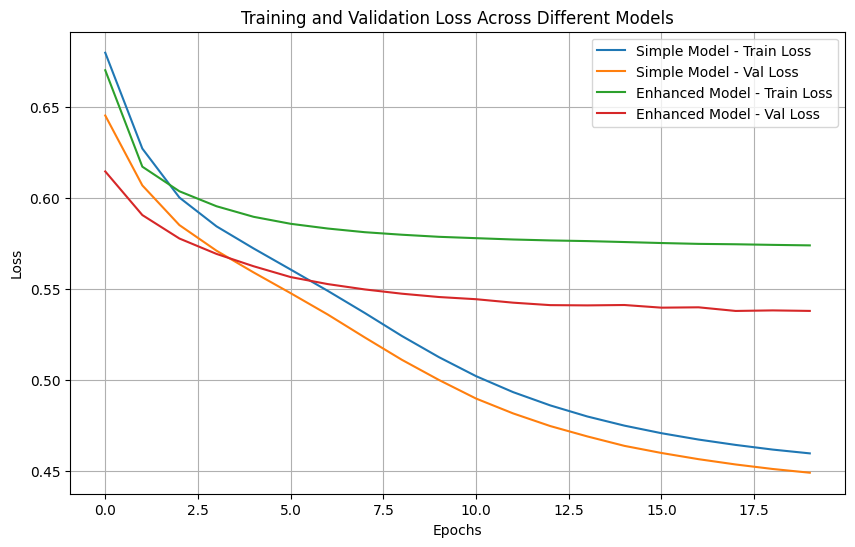

In [49]:
# Plot Training and Validation Losses for Different Models
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['train_losses'], label=f'{result["name"]} - Train Loss')
    plt.plot(result['val_losses'], label=f'{result["name"]} - Val Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Across Different Models')
plt.grid(True)
plt.show()


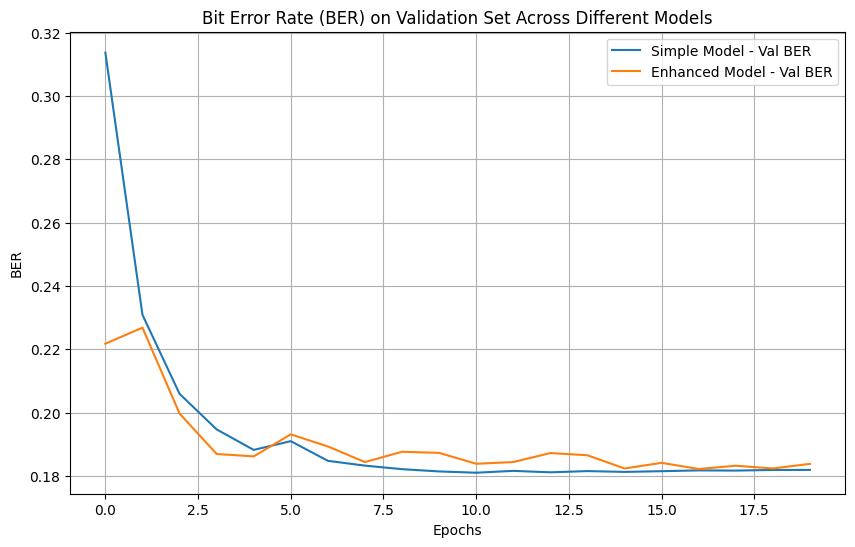

In [50]:
# Plot Validation BER for Different Models
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['val_BERs'], label=f'{result["name"]} - Val BER')

plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on Validation Set Across Different Models')
plt.grid(True)
plt.show()

In [61]:
del loss_fn
del optimizer
del scheduler

In [62]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
#--optimizer-1
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#--optimizer-2
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#--optimizer-3 
#optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

#added extra for better results
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6, verbose=True)

In [57]:
del model

In [58]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [59]:
model=model.to(device)

In [63]:
from tqdm.auto import tqdm
import numpy as np

# Initialize lists to store losses and BERs for visualization and analysis
train_losses = []
val_losses = []
val_BERs = []

# Training loop
start_epoch = 0
num_epochs = 20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(samples)  # forward pass
        loss = loss_fn(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)  # Save average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_total_loss = 0.0
    BER_batch = []
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)
            val_total_loss += val_loss.item()

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / labels.numel()  # Use numel() for total number of elements in labels
            BER_batch.append(error_rate.item())

    # Kapil=Calculate mean validation loss and mean BER for this epoch
    val_loss_mean = val_total_loss / len(val_loader)
    val_losses.append(val_loss_mean)  # Save mean validation loss for this epoch
    BER_batch_mean = np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)  # Save mean BER for this epoch

    # Use the mean validation loss for scheduler step
    scheduler.step(val_loss_mean)

    # Print or log training and validation results after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss_mean:.4f}, Val BER: {BER_batch_mean:.4f}")


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [1/20], Loss: 0.6669, Val Loss: 0.6356, Val BER: 0.2692


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [2/20], Loss: 0.6213, Val Loss: 0.6027, Val BER: 0.2102


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [3/20], Loss: 0.5985, Val Loss: 0.5844, Val BER: 0.2000


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [4/20], Loss: 0.5857, Val Loss: 0.5730, Val BER: 0.2086


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [5/20], Loss: 0.5757, Val Loss: 0.5635, Val BER: 0.1992


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [6/20], Loss: 0.5664, Val Loss: 0.5539, Val BER: 0.1944


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [7/20], Loss: 0.5568, Val Loss: 0.5442, Val BER: 0.1901


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [8/20], Loss: 0.5466, Val Loss: 0.5339, Val BER: 0.1950


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [9/20], Loss: 0.5361, Val Loss: 0.5233, Val BER: 0.1857


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [10/20], Loss: 0.5259, Val Loss: 0.5138, Val BER: 0.1875


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [11/20], Loss: 0.5160, Val Loss: 0.5041, Val BER: 0.1833


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [12/20], Loss: 0.5072, Val Loss: 0.4960, Val BER: 0.1836


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [13/20], Loss: 0.4996, Val Loss: 0.4883, Val BER: 0.1819


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [14/20], Loss: 0.4928, Val Loss: 0.4817, Val BER: 0.1813


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [15/20], Loss: 0.4870, Val Loss: 0.4761, Val BER: 0.1818


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [16/20], Loss: 0.4819, Val Loss: 0.4709, Val BER: 0.1821


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [17/20], Loss: 0.4773, Val Loss: 0.4663, Val BER: 0.1818


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [18/20], Loss: 0.4733, Val Loss: 0.4627, Val BER: 0.1821


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [19/20], Loss: 0.4699, Val Loss: 0.4590, Val BER: 0.1816


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [20/20], Loss: 0.4668, Val Loss: 0.4562, Val BER: 0.1823


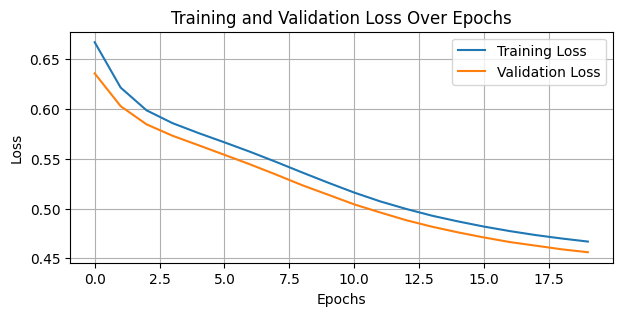

In [64]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)